# Choosing between earlier and later labels, after observing two groups

January 2025

In this experiment, participants observe the gameplay of two groups (the red group and the blue group), and choose between earlier and later labels based on their audience (the red group, the blue group, or either group) and goal (refer to the correct tangram, or be identified as a member of the audience group)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from memo import memo
import jax
import jax.numpy as jnp
import optax

from enum import IntEnum
from tqdm import tqdm

import utils

pd.set_option('future.no_silent_downcasting', True)
sns.set_context('talk')

## Model

In [2]:
class TangramTypes(IntEnum):
    shared = 0
    unique = 1


class Responses(IntEnum):
    later = 0
    earlier = 1  # this coding is counterintuitive, but corresponds to utterance length


class AudienceConditions(IntEnum):
    either = 0
    one = 1


class Audiences(IntEnum):
    ingroup = 1
    outgroup = 0

In [3]:
# type: ignore
@jax.jit
def audience_wpp(audience_condition, audience):
    # for the "either group" condition, return 1 regardless of audience
    # for the "one group" condition, return 1 for the ingroup and 0 for the outgroup
    return jnp.array([1, audience])[audience_condition]


@jax.jit
def ref_info(audience, tangram_type, utterance):
    ingroup_info = jnp.array([1, 1])  # [later, earlier]
    outgroup_info = jax.lax.cond(
        tangram_type == TangramTypes.shared,
        lambda _: jnp.array(
            [1, 1]
        ),  # if it's a shared-label tangram, the later utterance is informative regardless of group
        lambda _: jnp.array([0, 1]),
        operand=None,
    )

    info = jax.lax.cond(
        audience == Audiences.ingroup,
        lambda _: ingroup_info,
        lambda _: outgroup_info,
        operand=None,
    )

    return info[utterance]


@jax.jit
def social_info(utterance):
    return jnp.array([1, 0])[utterance]


@jax.jit
def cost(utterance):
    return jnp.array([0, 1])[utterance]


@memo
def speaker[
    utterance: Responses, audience: Audiences
](
    audience_condition: AudienceConditions,
    tangram_type: TangramTypes,
    alpha,
    w_r,
    w_s,
    w_c,
):
    cast: [speaker]
    speaker: chooses(
        audience in Audiences, wpp=audience_wpp(audience_condition, audience)
    )
    speaker: chooses(
        utterance in Responses,
        wpp=exp(
            alpha
            * (
                w_r * ref_info(audience, tangram_type, utterance)
                + w_s * social_info(utterance)
                - w_c * cost(utterance)
            )
        ),
    )
    return Pr[speaker.utterance == utterance]

## Load data

In [4]:
data = pd.read_csv("../data/3pp/earlier-later/selection_trials_clean.csv")
data.replace(
    {"response.earlier": {"earlier": Responses.earlier, "later": Responses.later}},
    inplace=True,
)
data.replace(
    {"shared": {"shared": TangramTypes.shared, "unique": TangramTypes.unique}},
    inplace=True,
)  # is it a shared or group-specific label?

data["shared"] = data["shared"].astype(int)
data["response.earlier"] = data["response.earlier"].astype(int)

data.head()

,subject_id,item_id,counterbalance,condition,audience_group,tangram,shared,response.earlier
0,dd2c8d9a-acab-46b0-a2d6-58e7c914ac4e,0,a,one social,red,C,0,0
1,dd2c8d9a-acab-46b0-a2d6-58e7c914ac4e,0,a,either refer,blue,B,0,0
2,dd2c8d9a-acab-46b0-a2d6-58e7c914ac4e,0,a,one social,blue,L,0,0
3,dd2c8d9a-acab-46b0-a2d6-58e7c914ac4e,0,a,one refer,blue,L,0,0
4,dd2c8d9a-acab-46b0-a2d6-58e7c914ac4e,0,a,one refer,red,H,1,1


Make a jax array for each condition

In [5]:
# masks for each condition
refer_either_mask = data["condition"] == "either refer"
refer_one_mask = data["condition"] == "one refer"
social_one_mask = data["condition"] == "one social"

# get the data for each condition
refer_either_tangram_types = jnp.array(data[refer_either_mask]["shared"].values)
refer_either_responses = jnp.array(data[refer_either_mask]["response.earlier"].values)

refer_one_tangram_types = jnp.array(data[refer_one_mask]["shared"].values)
refer_one_responses = jnp.array(data[refer_one_mask]["response.earlier"].values)

social_one_tangram_types = jnp.array(data[social_one_mask]["shared"].values)
social_one_responses = jnp.array(data[social_one_mask]["response.earlier"].values)

## Predict

Define speaker functions

In [6]:
@jax.jit
def speaker_refer_either(tangram_type, w_r, w_s, w_c):
    return speaker(
        audience_condition=AudienceConditions.either,
        tangram_type=tangram_type,
        alpha=1,
        w_r=w_r,
        w_s=0,
        w_c=w_c,
    )[1, 0]

@jax.jit
def speaker_refer_one(tangram_type, w_r, w_s, w_c):
    return speaker(
        audience_condition=AudienceConditions.one,
        tangram_type=tangram_type,
        alpha=1,
        w_r=w_r,
        w_s=0,
        w_c=w_c,
    )[1, 0]

@jax.jit
def speaker_social_one(tangram_type, w_r, w_s, w_c):
    return speaker(
        audience_condition=AudienceConditions.one,
        tangram_type=tangram_type,
        alpha=1,
        w_r=0,
        w_s=w_s,
        w_c=w_c,
    )[1, 0]

# vmap functions, for vectorizing the functions over the data
speaker_refer_either_vmap = jax.vmap(speaker_refer_either, in_axes=(0, None, None, None))
speaker_refer_one_vmap = jax.vmap(speaker_refer_one, in_axes=(0, None, None, None))
speaker_social_one_vmap = jax.vmap(speaker_social_one, in_axes=(0, None, None, None))

Compute preds

In [7]:
class ModelTypes(IntEnum):
    base = 0 
    social = 1

In [8]:
@jax.jit
def predict_all(
    model_type,
    refer_either_tangram_types,
    refer_one_tangram_types,
    social_one_tangram_types,
    w_r,
    w_s,
    w_c,
):
    """Generate predictions for all conditions"""
    preds_refer_either = speaker_refer_either_vmap(
        refer_either_tangram_types, w_r, w_s, w_c
    )
    preds_refer_one = speaker_refer_one_vmap(refer_one_tangram_types, w_r, w_s, w_c)
    preds_social_one = jax.lax.cond(
        model_type == ModelTypes.base,
        lambda _: speaker_refer_one_vmap(refer_one_tangram_types, w_r, w_s, w_c),
        lambda _: speaker_social_one_vmap(social_one_tangram_types, w_r, w_s, w_c),
        operand=None,
    )
    return preds_refer_either, preds_refer_one, preds_social_one


@jax.jit
def compute_NLL_all(
    model_type,
    refer_either_tangram_types,
    refer_one_tangram_types,
    social_one_tangram_types,
    refer_either_responses,
    refer_one_responses,
    social_one_responses,
    w_r,
    w_s,
    w_c,
):
    """compute NLL of whole dataset"""
    preds_refer_either, preds_refer_one, preds_social_one = predict_all(
        model_type,
        refer_either_tangram_types,
        refer_one_tangram_types,
        social_one_tangram_types,
        w_r,
        w_s,
        w_c,
    )
    NLL_refer_either = utils.compute_NLL(preds_refer_either, refer_either_responses)
    NLL_refer_one = utils.compute_NLL(preds_refer_one, refer_one_responses)
    NLL_social_one = utils.compute_NLL(preds_social_one, social_one_responses)
    return NLL_refer_either + NLL_refer_one + NLL_social_one

Fit params

In [9]:
def fit_params(
    model_type,
    initial_params,
    refer_either_tangram_types,
    refer_one_tangram_types,
    social_one_tangram_types,
    refer_either_responses,
    refer_one_responses,
    social_one_responses,
    lr=0.001,
    tol=1e-6,
    max_steps=10000,
):
    def loss_fn(params):
        return compute_NLL_all(
            model_type,
            refer_either_tangram_types,
            refer_one_tangram_types,
            social_one_tangram_types,
            refer_either_responses,
            refer_one_responses,
            social_one_responses,
            params[0],
            params[1],
            params[2],
        )

    grad_fn = jax.value_and_grad(loss_fn)
    params = jnp.array(initial_params, dtype=jnp.float32)
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(params)

    prev_nll = None
    for step in range(max_steps):
        nll_value, nll_grads = grad_fn(params)
        updates, opt_state = optimizer.update(nll_grads, opt_state)
        params = optax.apply_updates(params, updates)
        # ensure all params are positive
        params = params.at[:].set(jnp.clip(params[:], 0, jnp.inf))

        if step % 100 == 0:
            print(f"Step {step}, NLL value: {nll_value}, Params: {params}")

        if prev_nll is not None and abs(nll_value - prev_nll) < tol:
            print(f"Converged at step {step} with NLL={nll_value}")
            break

        prev_nll = nll_value

    best_nll = loss_fn(params)
    return params, best_nll

In [10]:
best_params_base, best_nll_base = fit_params(
    ModelTypes.base,
    [1, 0, 1],
    refer_either_tangram_types,
    refer_one_tangram_types,
    social_one_tangram_types,
    refer_either_responses,
    refer_one_responses,
    social_one_responses
)

Step 0, NLL value: 1412.2802734375, Params: [1.001 0.    0.999]
Step 100, NLL value: 1397.50048828125, Params: [1.0964491 0.        0.9051044]
Step 200, NLL value: 1389.14404296875, Params: [1.1794269 0.        0.8296031]
Step 300, NLL value: 1385.00390625, Params: [1.2507626 0.        0.7743507]
Step 400, NLL value: 1383.1494140625, Params: [1.3125845  0.         0.73840135]
Step 500, NLL value: 1382.311279296875, Params: [1.3673497 0.        0.7183489]
Step 600, NLL value: 1381.84814453125, Params: [1.4172218 0.        0.7094679]
Step 700, NLL value: 1381.5174560546875, Params: [1.4637127 0.        0.7072822]
Step 800, NLL value: 1381.2457275390625, Params: [1.5076579  0.         0.70850897]
Step 900, NLL value: 1381.015380859375, Params: [1.5493951 0.        0.7111677]
Step 1000, NLL value: 1380.82177734375, Params: [1.5889819 0.        0.7142428]
Step 1100, NLL value: 1380.6597900390625, Params: [1.6263644 0.        0.7172857]
Step 1200, NLL value: 1380.5260009765625, Params: [1.66

In [11]:
best_params_social, best_nll_social = fit_params(
    ModelTypes.social,
    [1, 1, 1],
    refer_either_tangram_types,
    refer_one_tangram_types,
    social_one_tangram_types,
    refer_either_responses,
    refer_one_responses,
    social_one_responses
)

Step 0, NLL value: 1488.1201171875, Params: [1.001 0.999 0.999]
Step 100, NLL value: 1451.3646240234375, Params: [1.0963882  0.90132517 0.9025556 ]
Step 200, NLL value: 1424.41064453125, Params: [1.1785582  0.8108408  0.81682086]
Step 300, NLL value: 1405.8704833984375, Params: [1.2470155 0.7289364 0.7434424]
Step 400, NLL value: 1393.973388671875, Params: [1.302449  0.656529  0.6834448]
Step 500, NLL value: 1386.88720703125, Params: [1.3462728  0.5940345  0.63720816]
Step 600, NLL value: 1382.956298828125, Params: [1.3804337  0.54124135 0.60424024]
Step 700, NLL value: 1380.882568359375, Params: [1.4071604  0.49732774 0.58313763]
Step 800, NLL value: 1379.79052734375, Params: [1.4286923 0.4610324 0.5717969]
Step 900, NLL value: 1379.171875, Params: [1.4470356  0.43091485 0.5678142 ]
Step 1000, NLL value: 1378.7725830078125, Params: [1.463796   0.4056054  0.56888974]
Step 1100, NLL value: 1378.4801025390625, Params: [1.4801083  0.38396734 0.5731043 ]
Step 1200, NLL value: 1378.24926757

Generate model predictions

In [12]:
# Base model preds
preds_refer_either_base, preds_refer_one_base, preds_social_one_base = predict_all(
    ModelTypes.base,
    refer_either_tangram_types,
    refer_one_tangram_types,
    social_one_tangram_types,
    *best_params_base
)

# Social model preds
preds_refer_either_social, preds_refer_one_social, preds_social_one_social = predict_all(
    ModelTypes.social,
    refer_either_tangram_types,
    refer_one_tangram_types,
    social_one_tangram_types,
    *best_params_social
)

In [13]:
# Put the predictions into a dataframe

tangram_types_mapping = np.vectorize(lambda x: TangramTypes(x).name)

preds_df_base = pd.DataFrame(
    {
        "condition": ["refer_either"] * len(preds_refer_either_base)
        + ["refer_one"] * len(preds_refer_one_base)
        + ["social_one"] * len(preds_social_one_base),
        "tangram_type": tangram_types_mapping(
            np.concatenate(
                [
                    refer_either_tangram_types,
                    refer_one_tangram_types,
                    social_one_tangram_types,
                ]
            )
        ),
        "response_earlier": np.concatenate(
            [
                refer_either_responses,
                refer_one_responses,
                social_one_responses,
            ]
        ),
        "p_earlier": np.concatenate(
            [
                preds_refer_either_base,
                preds_refer_one_base,
                preds_social_one_base,
            ]
        ),
        "model": "base",
    }
)

preds_df_social = pd.DataFrame(
    {
        "condition": ["refer_either"] * len(preds_refer_either_social)
        + ["refer_one"] * len(preds_refer_one_social)
        + ["social_one"] * len(preds_social_one_social),
        "tangram_type": tangram_types_mapping(
            np.concatenate(
                [
                    refer_either_tangram_types,
                    refer_one_tangram_types,
                    social_one_tangram_types,
                ]
            )
        ),
        "response_earlier": np.concatenate(
            [
                refer_either_responses,
                refer_one_responses,
                social_one_responses,
            ]
        ),
        "p_earlier": np.concatenate(
            [
                preds_refer_either_social,
                preds_refer_one_social,
                preds_social_one_social,
            ]
        ),
        "model": "social",
    }
)

preds_df = pd.concat([preds_df_base, preds_df_social])


In [14]:
preds_df

,condition,tangram_type,response_earlier,p_earlier,model
0,refer_either,shared,0,0.325894,base
1,refer_either,unique,0,0.530533,base
2,refer_either,unique,0,0.530533,base
3,refer_either,shared,0,0.325894,base
4,refer_either,unique,0,0.530533,base
...,...,...,...,...,...
2155,social_one,unique,0,0.287463,social
2156,social_one,shared,0,0.287463,social
2157,social_one,shared,0,0.287463,social
2158,social_one,shared,0,0.287463,social


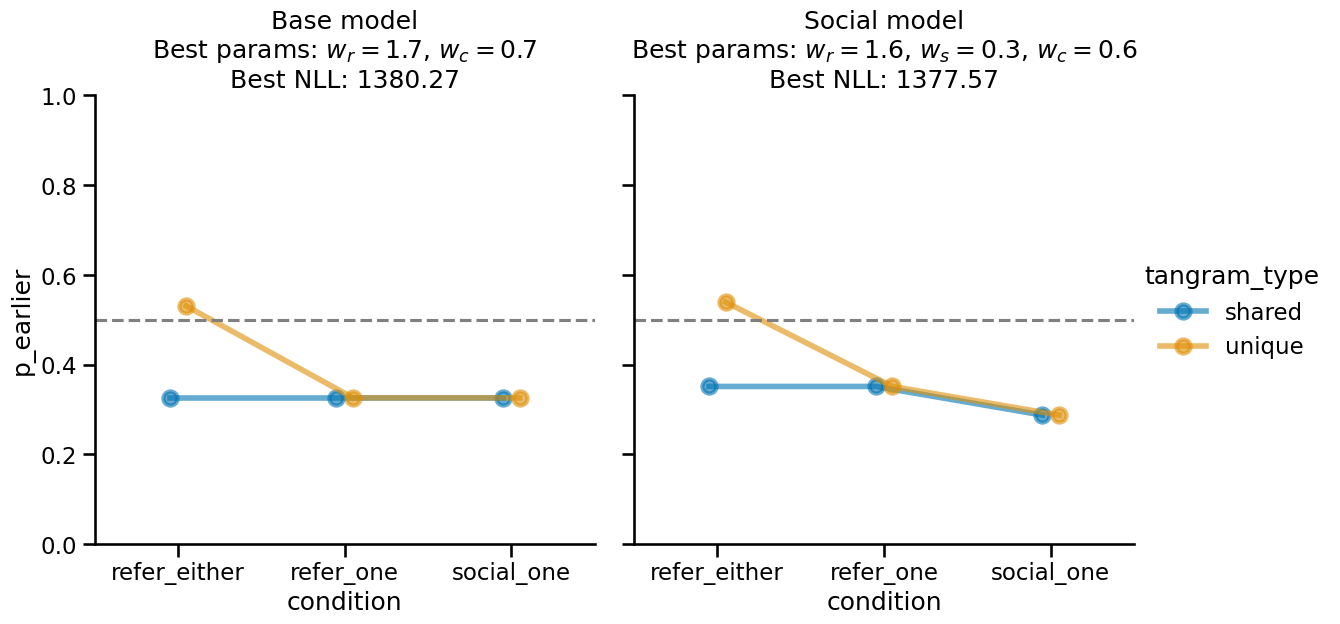

In [15]:
g = sns.catplot(
    data=preds_df,
    x="condition",
    y="p_earlier",
    hue="tangram_type",
    col="model",
    kind="point",
    height=6,
    aspect=1,
    palette="colorblind",
    dodge=0.1,
    alpha=0.6,
)

g.set(ylim=(0, 1))
for ax in g.axes.flat:
    ax.axhline(0.5, ls="--", color="gray")

titles = [f"Base model\nBest params: $w_r={best_params_base[0]:.1f}$, $w_c={best_params_base[2]:.1f}$\nBest NLL: {best_nll_base:.2f}", f"Social model\nBest params: $w_r={best_params_social[0]:.1f}$, $w_s={best_params_social[1]:.1f}$, $w_c={best_params_social[2]:.1f}$\nBest NLL: {best_nll_social:.2f}"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)


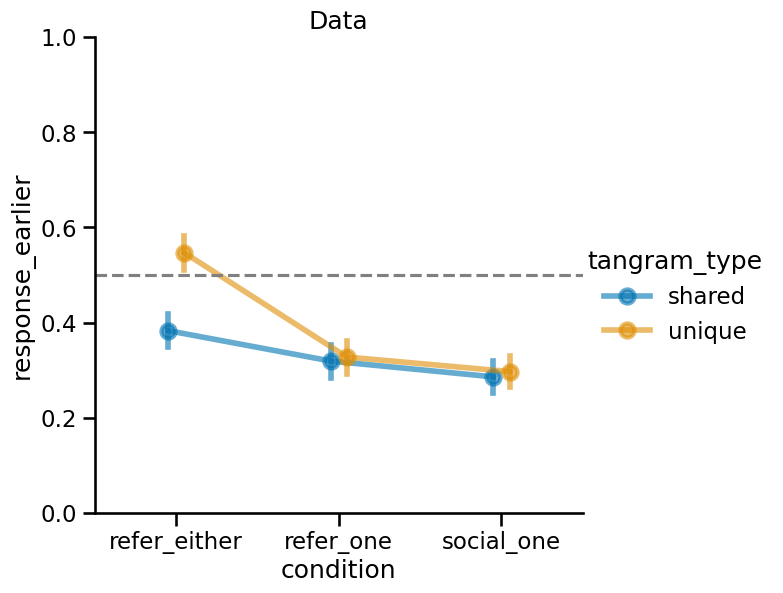

In [16]:
g = sns.catplot(
    data=preds_df,
    x="condition",
    y="response_earlier",
    hue="tangram_type",
    kind="point",
    height=6,
    aspect=1.1,
    palette="colorblind",
    dodge=0.1,
    alpha=0.6
)
g.set(ylim=(0, 1), title="Data")
for ax in g.axes.flat:
    ax.axhline(0.5, ls="--", color="gray")


LR test

In [17]:
from scipy.stats import chi2
lr_stat = 2 * (best_nll_base - best_nll_social)
df = 1  # social model has additional param w_s
p_val = chi2.sf(lr_stat, df)
lr_stat, p_val

(Array(5.392334, dtype=float32), 0.020225400724294275)